In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [2]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import torch
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
%load_ext autoreload
%autoreload 2

Reads 3 datasets: pure Jurkat cells, pure 293T, and a 50:50 mix of both. Concats them together and proceeds with standard Seurat preprocessing steps.
Dataset comes from: [Zheng et al, “Massively parallel digital transcriptional profiling of single cells”](http://www.nature.com/articles/ncomms14049).
Analysis tries to reproduce the methods used in: https://www.nature.com/articles/s41592-019-0619-0

In [4]:
jurkat = sc.read_10x_mtx(
    'data/jurkat_raw_gene/hg19/',  
    var_names='gene_symbols',
    cache=True)
half = sc.read_10x_mtx(
    'data/jurkat_293t_50_50_raw_gene/hg19/',  
    var_names='gene_symbols',
    cache=True)
t293 = sc.read_10x_mtx(
    'data/293t_raw_gene/hg19/',  
    var_names='gene_symbols',
    cache=True)

In [5]:
# assignment of cells from 50:50 dataset to cell_type
# taken from: https://github.com/immunogenomics/harmony2019/blob/master/data/figure2/metadata.csv
metadata = pd.read_csv("data/metadata.csv")
metadata.head()

,cell_id,dataset,nGene,percent_mito,cell_type
0,half_AAACATACAGCTAC,half,5057,0.025909,t293
1,half_AAACATTGTAAGGA,half,2291,0.019852,jurkat
2,half_AAACCGTGGCGTAT,half,2792,0.018896,jurkat
3,half_AAACGCACTACTGG,half,2717,0.015039,jurkat
4,half_AAACGCTGAAGATG,half,3962,0.017723,jurkat


## Basic preprocessing

"We filtered cells with fewer than 500 genes or more than 20% mitochondrial reads. […] We then library normalized each cell to 10,000 reads, by multiplicative scaling, then log scaled the normalized data. We then identified the top 1,000 variable genes, ranked by coefficient of variation, within in each dataset. We pooled these genes to form the variable gene set of the analysis. Using only the variable genes, we mean centered and variance 1 scaled the genes across the cells. Note that this was done in the aggregate matrix, with all cells, rather than within each dataset separately. With these values, we performed truncated singular value decomposition keeping the top 30 eigenvectors. Finally, we multiplied the cell embeddings by the eigenvalues to avoid giving eigenvectors equal variance."

source code: https://github.com/immunogenomics/harmony2019/blob/master/notebooks/Fig2_Celllines.ipynb

In [6]:
jurkat.obs.rename(index=lambda s: "jurkat_" + s.replace("-1", ""), inplace=True)
half.obs.rename(index=lambda s: "half_" + s.replace("-1", ""), inplace=True)
t293.obs.rename(index=lambda s: "t293_" + s.replace("-1", ""), inplace=True)

In [7]:
sc.pp.filter_cells(jurkat, min_genes=500)
sc.pp.filter_cells(half, min_genes=500)
sc.pp.filter_cells(t293, min_genes=500)

In [8]:
jurkat.var['mt'] = jurkat.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(jurkat, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

half.var['mt'] = half.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(half, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

t293.var['mt'] = t293.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(t293, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

In [9]:
jurkat = jurkat[jurkat.obs.pct_counts_mt < 20, :]
half = half[half.obs.pct_counts_mt < 20, :]
t293 = t293[t293.obs.pct_counts_mt < 20, :]

In [10]:
adatas = {
    "jurkat": jurkat,
    "half": half,
    "293t": t293
}
adata = ad.concat(adatas, label="dataset")
adata

AnnData object with n_obs × n_vars = 9913 × 32738
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset'

In [11]:
adata.obs.loc[metadata.cell_id, "cell_type"] = metadata.cell_type.to_numpy().astype(str)

In [12]:
adata = adata[~adata.obs.cell_type.isna()]

In [13]:
adata.obs

,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,dataset,cell_type
jurkat_AAACATACACTGTG,2870,2870,12034.0,456.0,3.789263,jurkat,jurkat
jurkat_AAACCGTGACCACA,3348,3348,14360.0,384.0,2.674095,jurkat,jurkat
jurkat_AAACCGTGCACTTT,3258,3258,16280.0,583.0,3.581081,jurkat,jurkat
jurkat_AAACCGTGGCGTTA,3503,3503,18077.0,569.0,3.147646,jurkat,jurkat
jurkat_AAACCGTGTGAGAA,3911,3911,21968.0,586.0,2.667516,jurkat,jurkat
...,...,...,...,...,...,...,...
t293_TTTCTACTAGCCTA,3500,3500,14573.0,254.0,1.742949,293t,t293
t293_TTTCTACTTCGATG,2924,2924,10107.0,268.0,2.651628,293t,t293
t293_TTTGACTGAAAACG,3446,3446,16136.0,537.0,3.327962,293t,t293
t293_TTTGACTGGTGCTA,3425,3425,16384.0,516.0,3.149414,293t,t293


In [14]:
sc.pp.normalize_total(adata, target_sum=1e4)

/media/gambino/students_workdir/anna/miniconda3/envs/ak/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [15]:
sc.pp.log1p(adata)

In [16]:
adata

AnnData object with n_obs × n_vars = 9478 × 32738
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'cell_type'
    uns: 'log1p'

In [17]:
sc.pp.highly_variable_genes(adata, n_top_genes=1000, batch_key="dataset")

/media/gambino/students_workdir/anna/miniconda3/envs/ak/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:485: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hvg = hvg.append(missing_hvg, ignore_index=True)
/media/gambino/students_workdir/anna/miniconda3/envs/ak/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:485: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hvg = hvg.append(missing_hvg, ignore_index=True)
/media/gambino/students_workdir/anna/miniconda3/envs/ak/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:485: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hvg = hvg.append(missing_hvg, ignore_index=True)


In [18]:
adata.raw = adata

In [19]:
adata = adata[:, adata.var.highly_variable]
adata

View of AnnData object with n_obs × n_vars = 9478 × 1000
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'cell_type'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'log1p', 'hvg'

In [20]:
sc.pp.scale(adata, max_value=10)

/media/gambino/students_workdir/anna/miniconda3/envs/ak/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [21]:
sc.tl.pca(adata, svd_solver='arpack')

In [22]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

In [23]:
sc.tl.umap(adata)

### Figure 2d

/media/gambino/students_workdir/anna/miniconda3/envs/ak/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


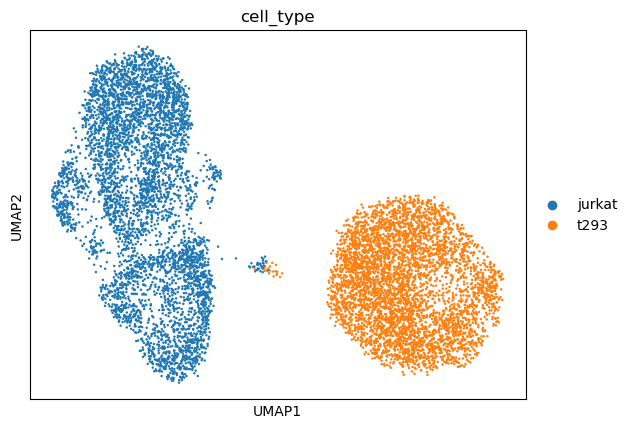

In [278]:
sc.pl.umap(adata, color=['cell_type'])

### Figure 2c

/media/gambino/students_workdir/anna/miniconda3/envs/ak/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


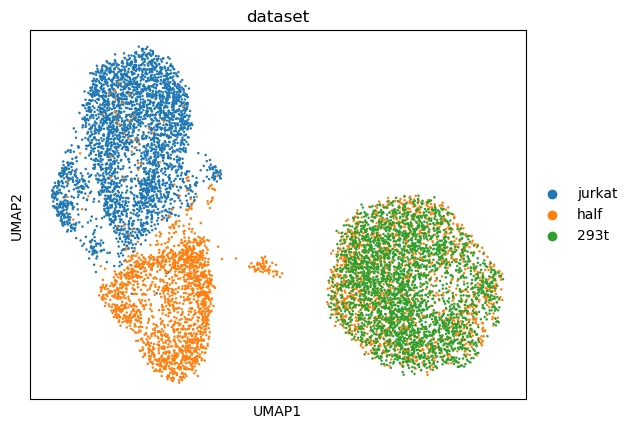

In [279]:
sc.pl.umap(adata, color=['dataset'])

## Compute LISI

In [26]:
from src.loss import compute_lisi

In [27]:
x = torch.Tensor(adata.X).to("cuda")

In [28]:
adata.obs["cell_type_id"] = pd.Categorical(
            pd.factorize(adata.obs.loc[:, "cell_type"])[0]
        )

In [29]:
adata.obs["dataset_id"] = pd.Categorical(
            pd.factorize(adata.obs.loc[:, "dataset"])[0]
        )

In [30]:
cell_type_id = torch.ByteTensor(adata.obs["cell_type_id"].values).to("cuda")
dataset_id = torch.ByteTensor(adata.obs["dataset_id"].values).to("cuda")

In [297]:
cell_type_lisi = compute_lisi(x, cell_type_id, 2)

In [310]:
cell_type_lisi_np = cell_type_lisi.cpu().numpy()
cell_type_lisi_np

array([1.0000005 , 0.9999995 , 1.0000001 , ..., 0.99999976, 1.0000004 ,
       1.0000001 ], dtype=float32)

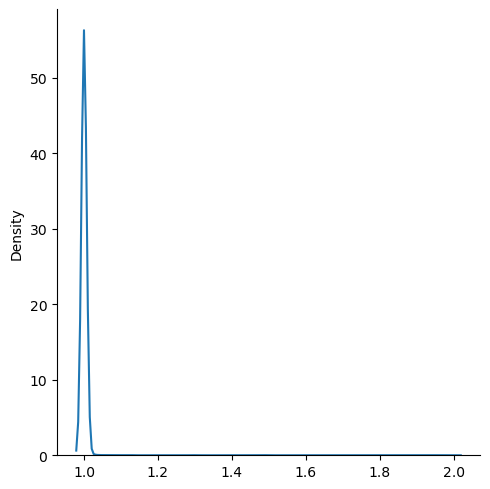

In [317]:
sns.displot(data=cell_type_lisi_np, kind="kde")

In [34]:
dataset_lisi = compute_lisi(x, dataset_id, 3)

In [35]:
dataset_lisi_np = dataset_lisi.cpu().numpy()
dataset_lisi_np

array([1.0045675, 1.0723805, 1.0000001, ..., 1.9086951, 1.8058641,
       1.573802 ], dtype=float32)

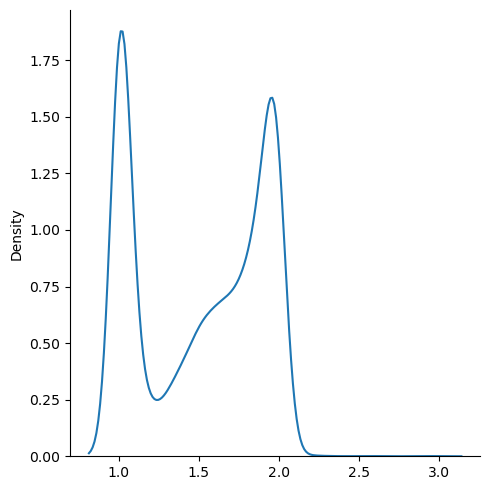

In [36]:
sns.displot(data=dataset_lisi_np, kind="kde")

# Try to batch correct data (loss = MSE + 0.001 * sum(1/LISI))

In [25]:
from src.types import TrainParams
train_params = TrainParams(train_size=0.8, n_epochs=100, learning_rate=1e-4, batch_size=128, params_file="benchmark_jurkat")

In [26]:
from src.vae.model import VAE
from src.model import ModelParams

model_params = ModelParams(beta=0.01, n_layers=2, z_dim=100, n_hidden=300, use_cuda=True)
torch.set_num_threads(16)

model = VAE(adata, model_params)

In [27]:
# from src.vae.train import train_vae
# hist = train_vae(model, adata, batch_key="dataset", params=train_params)

model_dict = torch.load('mvae_params/benchmark_jurkat_20230327-233101.pt', map_location='cuda')
model.load_state_dict(model_dict)

<All keys matched successfully>

/media/gambino/students_workdir/anna/miniconda3/envs/ak/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


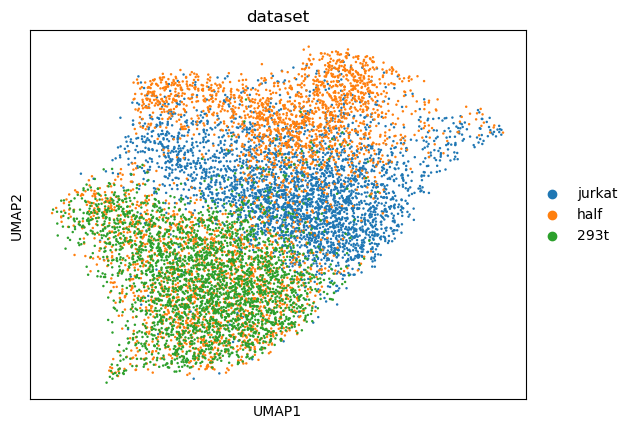

/media/gambino/students_workdir/anna/miniconda3/envs/ak/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


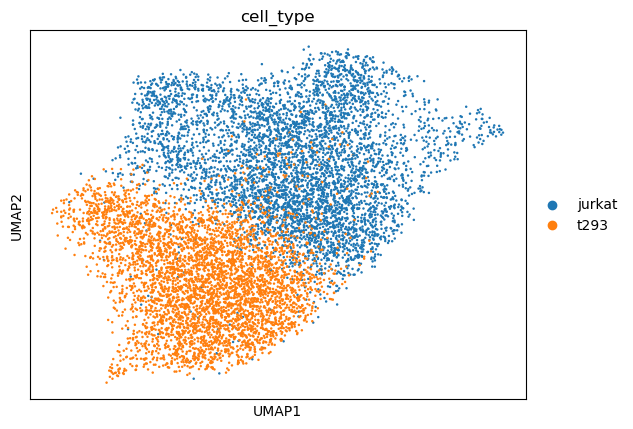

In [44]:
sc.pl.umap(adata, color=["dataset"])
sc.pl.umap(adata, color=["cell_type"])

In [47]:
from src.vae.diagnostics import batch_integration
lisi = batch_integration(model, adata, 3, "dataset", train_params)

100%|███████████████████████████████████████████| 75/75 [00:04<00:00, 18.13it/s]


In [55]:
lisi_np = lisi.cpu().numpy()
lisi_np

array([2.0746825, 2.2238073, 2.149695 , ..., 2.720667 , 2.4886434,
       2.9733791], dtype=float32)

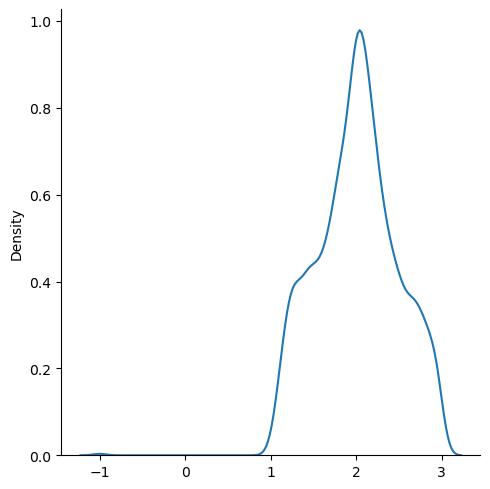

In [49]:
sns.displot(data=lisi_np, kind="kde")

In [29]:
from src.vae.diagnostics import batch_integration
lisi = batch_integration(model, adata, 2, "cell_type", train_params)

100%|███████████████████████████████████████████| 75/75 [00:03<00:00, 21.63it/s]


In [45]:
lisi_cell_type_np = lisi.cpu().numpy().round(2)
lisi_cell_type_np = lisi_cell_type_np[lisi_cell_type_np >= 0]

In [44]:
lisi_cell_type_np[lisi_cell_type_np < 1].round(2)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1.], dtype=float32)

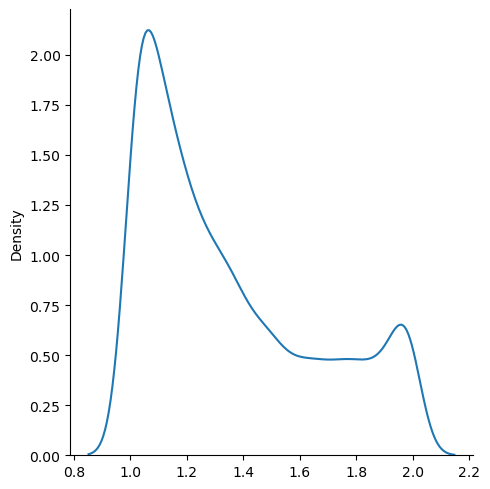

In [55]:
sns.displot(data=lisi_cell_type_np, kind="kde")